[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NxTAjQA3N9AQzS4VD_QlvDCOBm3by__u?usp=sharing)

# Convolutional Networks

We've talked about the "MLP" architecture in previous lessons, in which inputs to the next layer of neurons are "fully connected" (everything is conntected to everything else). 

It turns out that for many applications in computer vision and signal processing, one can make great use of layers that look at only "local" (or "nearby") information, and then have the outpouts of those be combined at successively larger spatial (or temporal) scales.  This is what's known as a *local receptive field*, and is based directly on the biology of neurons in the visual cortex:

![neuron receptive field](https://i.imgur.com/KC4PsPc.png)
(Image source: http://neuroclusterbrain.com/neuron_model.html)

This idea was exploided in the ["Neocognitron" model](https://link.springer.com/article/10.1007/BF00344251) which built off the Nobel-prize winning work of Hubel & Weisel with cat vision, and how the different neurons in the cat brain learn to function as "pattern recognizers" for things like edges:

<iframe width="560" height="315" src="https://www.youtube.com/embed/IOHayh06LJ4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>





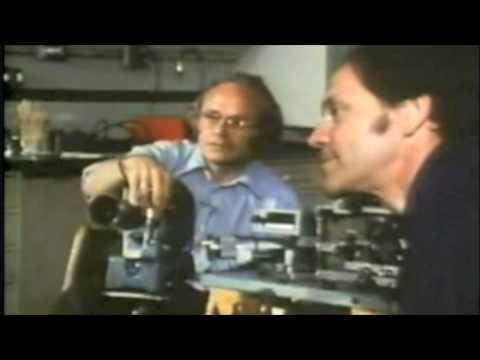

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('IOHayh06LJ4')


This work led to the development of the important "LeNet" architecture used by Yann LeCun and collaborators at Bell Labs, where this "local receptive field" is extendended though multiple layers that "stack up" a increasingly "zoomed out" version of the image.  
![lenet arch](https://cdn.inblog.in/user/uploads/b4b07bff68d8edf68622a0bb31b8aacd.png) Source: LeCun et al. 

At each stage, multiple "filter banks" exist, which filter different parts of the image.  As an illustration of this effect, consider this visualization of layer activations or "feature maps" at successive stages of a convolutional neural network being used for facial recognition:
![layer feature maps](https://hedges.belmont.edu/scottergories/images/lee_et_all_faces.png) 
(Image source: Lee et al, 2009) 

Notice how the low-level features detect various kinds of edges (as with the cat neurons), which are combined via later layers in to "mid-level features" such as eyes and noses, and finally later layers for full face images.






## So what's convolution?
Convolution is a "running" dot product of a (typically smaller) vector or matrix called the "kernel" that is "run over" a larger vector or matrix representing a signal or image.  The important point is that it's the SAME set of weights being applied *all over* the image.  This is closely related to the notion that we often want our networks to be invariant to translations in space or time.  An example you're probably familiar with is  "running average", in which the kernel is a set of constant weights.  A different example would be a "blur" filter used in photo editing, in which a weighted local average of nearby points becomes the next point.

The convolution kernel functions as a filter.  In the interactive demo below, convolution kernel in the middle is "run over" each point of the input image, and then the dot product of the (local) image pixels and the kernel becomes the new pixel in the new image. Try clicking on the point in the 3x3 kernel, and notice how the shape of the kernel tends to match whats "allowed to pass through" the filter to make up the output image:

<iframe type="text/html" src="https://hedges.belmont.edu/~shawley/acts/demo/demo_draw.html" width="700px" height="280px" frameborder="0">
 </iframe>

In [2]:
from IPython.display import HTML, IFrame 
print("Choose a kernel preset from the drop-down or click on the squares to create your own kernel.")
HTML('<iframe type="text/html" src="https://hedges.belmont.edu/~shawley/acts/demo/demo_draw.html" width="700px" height="280px" frameborder="0"></iframe>')
#IFrame('https://hedges.belmont.edu/~shawley/acts/demo/demo_draw.html', width=700, height=280)

Choose a kernel preset from the drop-down or click on the squares to create your own kernel.


With this conceptual understanding under your belt, take a look at [this great medium post by Daphne Cornelisse](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/) 
to fill in more details of how convolution works -- note that we're going to use PyTorch code instead of Keras. 

## Convolutions and Correlations
As another way to think about convolutions -- and to give a 1D example ("signal processing") instead the 2D ("computer vision") exercises we've been doing, here's another interactive Javascript demo you can try, in the input signal is "convolved" with the second "kernel" signal.  The remainder of the demo shows the resulting filtered signal as well as the "correlation cofficient"  -- which is the familiar correlation coefficient "R" from other areas of statistics & science!  Notice that signals that "make it through" the kernel-filter are highly correlated, and vice versa.

In [3]:
IFrame('https://hedges.belmont.edu/signal_corr_trans.html', width=800, height=650)

# MNIST MLP & CNN Demo

[MNIST](http://yann.lecun.com/exdb/mnist/) is a classic dataset of handwritten digits, which has been the testing ground for a [a variety of methods](https://en.wikipedia.org/wiki/MNIST_database)(Wikipedia) in machine learning.

![MNIST example](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

While Convolutional Neural Networks -- which we'll get to below -- tend to be most effective and for image processing, the 24x24-pixel images in MNIST are small enough that we can apply the 'single hidden layer' model  (also known as a Multi-Layer Perceptron or MLP)  to it.  

Essentially, we will 'graduate' from the 7-segment display of digits from the previous lesson, to handwritten digits.  Then we'll move on to larger, more diverse image datasets.

## First, check that we can use a GPU (runs faster)

In [4]:
# First, confirm that we can see the GPU. Just execute this cell. 
import torch
torch.cuda.is_available()   # If False, go up to Edit > Notebook Settings > Hardware Accelerator > GPU

True

In [5]:
# install some things
! [ -e /content ] && pip install -Uqq fastai   # install upgrade fastai on colab
! pip install mrspuff -Uq

In [6]:
# let's import a bunch of other stuff
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
from fastai.learner import Learner
from fastai.optimizer import OptimWrapper
from fastai.callback.progress import *
from functools import partial 
from IPython.display import display, HTML

## Download and prepare the data:

We're going to write our neural networks using [Keras](http://keras.io), which also provides handy utility for downloading and setting up common ML datasets.

In [7]:
# Download the data
path = untar_data(URLs.MNIST)  # fastai stores the url in URLs.MNIST

path.ls()  # let's see what's there. Note we could just as easily run "! ls {path}" instead

(#3) [Path('/root/.fastai/data/mnist_png/models'),Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

So, there's a training set and a testing set.  Let's take a look in testing:

In [8]:
(path/"testing").ls()

(#10) [Path('/root/.fastai/data/mnist_png/testing/8'),Path('/root/.fastai/data/mnist_png/testing/9'),Path('/root/.fastai/data/mnist_png/testing/5'),Path('/root/.fastai/data/mnist_png/testing/4'),Path('/root/.fastai/data/mnist_png/testing/2'),Path('/root/.fastai/data/mnist_png/testing/6'),Path('/root/.fastai/data/mnist_png/testing/7'),Path('/root/.fastai/data/mnist_png/testing/1'),Path('/root/.fastai/data/mnist_png/testing/0'),Path('/root/.fastai/data/mnist_png/testing/3')]

...So there's a seperate directory for each digit (0 to 9).  Each digit will be regarded as a category for our classifier. And then in one of the digit directories:

In [9]:
(path/"testing/8").ls()

(#974) [Path('/root/.fastai/data/mnist_png/testing/8/373.png'),Path('/root/.fastai/data/mnist_png/testing/8/3829.png'),Path('/root/.fastai/data/mnist_png/testing/8/3954.png'),Path('/root/.fastai/data/mnist_png/testing/8/8266.png'),Path('/root/.fastai/data/mnist_png/testing/8/9596.png'),Path('/root/.fastai/data/mnist_png/testing/8/8135.png'),Path('/root/.fastai/data/mnist_png/testing/8/8919.png'),Path('/root/.fastai/data/mnist_png/testing/8/7035.png'),Path('/root/.fastai/data/mnist_png/testing/8/1052.png'),Path('/root/.fastai/data/mnist_png/testing/8/2667.png')...]

If we and to take a look at one, we go do...

In [10]:
image = Image.open((path/"testing/8").ls()[0]) # this will take the first filename in the list and open it as an Image
image   # have the notebook display the image -- it's an 8! (or it should be)

In [11]:
image.size, image.mode   #  dimesions of image are 28x28.  'L' mode means grayscale

((28, 28), 'L')

## Define the DataSets
We're going to use fastai, which has various built-in methods for reading categorical data. Most of these methods assume our images are RGB rather than grayscale. In order to keep our image grayscale, we'll have to do a little extra work by defining a DataBlock, that will store our images, their categories, and how to load them.

In [12]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y = parent_label)

In [ ]:
batch_size = 64  # they're tiny, black & white images
dls = mnist.dataloaders(path, bs=batch_size)

In [ ]:
dls.show_batch()  

In [ ]:
# let's check to make sure we're still grayscale:
print(dls.train_ds[0][0].shape)   # should be (28,28)
print(dls.one_batch()[0].shape)   # should have a 1 not a 3 for the second dimension

## Define a Model & Learner
First we'll start with a *non*-convolutional model, an MLP:

In [ ]:
# i want to use torchinfo.summary so we can see how many parameters are in our model
!pip install torchinfo 
from torchinfo import summary

In [ ]:
# fastai does moves our model to the gpu automatically, but I want to use 
# torchinfo.summary first to see what our models' "made of", so we need to 
# know what device we're on.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The PyTorch model looks similar:
net = nn.Sequential(   # Sequential is a simplified interface that defines our .__init__() and .forward() method for us
    nn.Flatten(),     # convert the data from being square to one big long line
    nn.Linear(784, 256),  # 784 = 28x28  
    nn.ReLU(),
    nn.Linear(256, 128),   
    nn.ReLU(),
    nn.Linear(128,10),     # ten categories for digits 0-9 on the output
    nn.LogSoftmax(dim=1) # softmax is like sigmoid for multi-class. Log-softmax is more accurate as our "Santa" example indicated
    ).to(device)

summary(net, input_size=(batch_size, 1, 28, 28))

Note (for later) that there's 235,000 trainable parameters in this model.

Oh, remember WandB!  Yea, we should use it!


In [ ]:
use_wandb = False
if use_wandb:
    !pip install wandb -qqq
    import wandb
    from fastai.callback.wandb import *
    wandb.login()

In [ ]:
if use_wandb:
    wandb.finish()  # stop any aborted previous runs (I made a lot of mistake preparing this!)
    wandb.init(project='mnist_lesson6')
    cbs = WandbCallback()
else:
    cbs = []

opt_func = partial(OptimWrapper, opt=optim.Adam)  # Optimizer method


# NLLLoss is negative log-likelihood, and it pairs with our LogSoftMax activation
learn = Learner(dls, net, metrics=accuracy, opt_func=opt_func, loss_func=nn.NLLLoss(), cbs=cbs)

In [ ]:
#what learning rate to use?  Let's let the LR Finder tell us:
learn.lr_find()

In [ ]:
learn.fit(10, lr=1e-3)
if use_wandb: wandb.finish()

So we get an accuracy of around 97% with our MLP, along with a validation loss of 0.13, and a much lower training loss -- indicating that our model is significantly *overfitting*.  

 Let's try a Convolutional Neural Network (CNN or 'ConvNet') instead.

The standard fastai convnet architectures are known as ResNets, which come in different sizes (e.g. resnet18, resnet34).  

But we're going to define our own convnet...

## Define the CNN model

In [ ]:
class ConvNet(nn.Module):
    # from PyTorch tutorial, https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L36
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # We have the option to build our network in "blocks". 
        #   We don't have to, but let's try it
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(16),  # Try coming back and uncommenting these BatchNorm lines and re-training! ;-) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)  #  a final fully connected layer
        self.act = nn.LogSoftmax(dim=1) # as I was writing this I forgot the softmax and nothing converged. ;-) 

    def forward(self, x, pretrained=False):
        out = self.block1(x)
        out = self.block2(out)
        out = out.reshape(out.size(0), -1) # this is like nn.Flatten()
        out = self.fc(out)
        out = self.act(out)
        return out

cnn = ConvNet().to(device)
summary(cnn, input_size=(batch_size, 1, 28, 28))

...So, only 29,000 parameters instead of the MLP's 230,000!. 


## And train as before...

In [ ]:
if use_wandb:
    wandb.finish() 
    wandb.init(project='mnist_lesson6')

learn = Learner(dls, cnn, metrics=accuracy, opt_func=opt_func, loss_func=nn.NLLLoss(), cbs=cbs)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(10, lr=1e-3)
if use_wandb: wandb.finish()

The loss values with the CNN were quite a bit lower than they were with the MLP, yes?  Correspondingly, we scored higher in accuracy too. And while training loss validation losses remained more commensurate -- less overfitting!  

There are many variations we can apply to this model, adding layers with names such as "Dropout" and "Batch Normalization" too.  For now this will suffice.


**Questions for in-class discussion:**
1. If the CNN is supposed to be faster than the MLP for *most* applications, why is it *no faster* on the MNIST dataset?
2. Did you try the BatchNorm?  What did it do?